
# Owen (Qwen2.5-Coder) CWE Classification — Experiments Notebook

This notebook lets you run a set of **controlled experiments** for the Owen (Qwen 2.5 Coder) model on your Go CWE dataset.
It supports:

- **Modes**: Head-only (frozen base) and **LoRA** partial fine-tuning
- **Pooling**: Masked **mean** vs **last-token** pooling
- **Prompt prefix**: On/Off (`[LANG:go][TASK:CWE_CLASSIFICATION]\n`)
- **Hyperparameters**: Choose LR/epochs/batch sizes per mode
- **Metrics**: Returns exactly the dict structure you specified and saves JSON/CSV
- **Plots**: Confusion matrix, per-class F1 bar chart, and a heatmap of per-CWE accuracy
- **Reproducibility**: Fixed seeds, stratified 70/15/15 split

> Hardware target: **RTX 3090 24GB**


## 1) Environment setup

In [12]:
!CUDA_AVAILABLE_DEVICES=1
!TOKENIZERS_PARALLELISM=false

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:

# If you're in Colab or a fresh environment, run this first.
# (Restart the kernel after installs if prompted.)

try:
    import torch
    print("Torch version:", torch.__version__)
except Exception as e:
    print("PyTorch not found. It will be installed below.")

%pip -q install --upgrade pip
%pip -q install "transformers" "accelerate" "bitsandbytes" \
                "peft" "scikit-learn" "pandas" "matplotlib" \
                "numpy" "tqdm"


Torch version: 2.7.0+cu126


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


## 2) Configuration

In [ ]:

from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple
import os, random, time, json, math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup
from transformers.utils import logging as hf_logging
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel

hf_logging.set_verbosity_error()

DATA_PATH = "./go_cwe_7k-augmented+real-v3.jsonl"  # update if needed
OUTPUT_DIR = "./owen_experiments"
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODEL_NAME = "Qwen/Qwen2.5-Coder-1.5B"
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

USE_PREFIX_DEFAULT = True
PROMPT_PREFIX = "[LANG:go][TASK:CWE_CLASSIFICATION]\n"
MAX_LENGTH = 1024  # Trim to fit GPU memory

BATCH_SIZE = 4 
GRAD_ACCUM_STEPS = 4 
EPOCHS_HEAD = 4
EPOCHS_LORA = 4
LR_HEAD = 1e-3
LR_LORA = 2e-4
EARLY_STOP_PATIENCE = 2 
VAL_EVAL_STEPS = None 
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

device = torch.device("cuda:1")
print("Device:", device)


Device: cuda:1


## 3) Load data & create stratified splits (70/15/15)

In [ ]:

def read_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

raw = read_jsonl(DATA_PATH)
print(f"Loaded {len(raw)} records from {DATA_PATH}")

codes, labels = [], []
for r in raw:
    code = r.get("code") or r.get("text") or ""
    cwe = r.get("cwe") or r.get("label")
    if code is None or cwe is None:
        continue
    codes.append(code)
    labels.append(int(cwe))

codes = np.array(codes)
labels = np.array(labels)

unique_labels = sorted(np.unique(labels).tolist())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}
y_indices = np.array([label2id[l] for l in labels])

print("Num classes:", len(unique_labels))
print("Label -> idx map (first 10):", list(label2id.items())[:10])

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
trainval_idx, test_idx = next(sss1.split(codes, y_indices))

codes_trainval, y_trainval = codes[trainval_idx], y_indices[trainval_idx]
codes_test, y_test = codes[test_idx], y_indices[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1765, random_state=SEED)
train_idx, val_idx = next(sss2.split(codes_trainval, y_trainval))

codes_train, y_train = codes_trainval[train_idx], y_trainval[train_idx]
codes_val, y_val = codes_trainval[val_idx], y_trainval[val_idx]

print(f"Train/Val/Test sizes: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")


Loaded 7600 records from ./synthetic_go_cwe_7k-augmented+real-v3.jsonl
Num classes: 20
Label -> idx map (first 10): [(20, 0), (22, 1), (78, 2), (79, 3), (89, 4), (94, 5), (125, 6), (190, 7), (200, 8), (269, 9)]
Train/Val/Test sizes: 5319/1141/1140


## 4) Tokenizer & Dataset

In [34]:

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def build_input(code: str, use_prefix: bool) -> str:
    return (PROMPT_PREFIX + code) if use_prefix else code

class GoCweDataset(Dataset):
    def __init__(self, texts, y, use_prefix=True):
        self.texts = texts
        self.y = y
        self.use_prefix = use_prefix
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = build_input(self.texts[idx], self.use_prefix)
        return {"text": text, "label": int(self.y[idx])}

def collate_fn(batch):
    texts = [b["text"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    enc = tokenizer(texts, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt")
    return {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"], "labels": labels}

train_ds = GoCweDataset(codes_train, y_train, use_prefix=USE_PREFIX_DEFAULT)
val_ds   = GoCweDataset(codes_val, y_val, use_prefix=USE_PREFIX_DEFAULT)
test_ds  = GoCweDataset(codes_test, y_test, use_prefix=USE_PREFIX_DEFAULT)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

len(train_ds), len(val_ds), len(test_ds)
device


device(type='cuda', index=1)

## 5) Model wrapper (pooled hidden states + classification head)

In [ ]:

class OwenClassifier(nn.Module):
    def __init__(self, base_model, hidden_size: int, num_labels: int, pooling: str = "mean"):
        super().__init__()
        self.base = base_model
        self.pooling = pooling  # "mean" or "last"
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, **kwargs)
        last_hidden = outputs.hidden_states[-1]

        if self.pooling == "mean":
            # masked mean
            mask = attention_mask.unsqueeze(-1) 
            summed = torch.sum(last_hidden * mask, dim=1)
            count = torch.clamp(mask.sum(dim=1), min=1)
            pooled = summed / count
        else:
            # last-token of each sequence (by attention mask)
            lengths = attention_mask.sum(dim=1) - 1 
            pooled = last_hidden[torch.arange(last_hidden.size(0), device=last_hidden.device), lengths]

        pooled = pooled.to(self.classifier.weight.dtype)
        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits}

def load_qwen_base_4bit(model_name: str):
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map={"": 1},
        torch_dtype=torch.float16,
        load_in_4bit=True
    )
    hidden_size = base.config.hidden_size
    return base, hidden_size


## 6) Training & evaluation utilities

In [ ]:

def set_trainable(module: nn.Module, trainable: bool):
    for p in module.parameters():
        # p.requires_grad = trainable
        if hasattr(p, "dtype") and (p.dtype.is_floating_point or p.is_complex()):
            p.requires_grad = trainable

def count_trainable_params(module: nn.Module) -> int:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate(model: nn.Module, data_loader: DataLoader, num_labels: int) -> Dict[str, Any]:
    model.eval()
    all_logits = []
    all_labels = []
    inference_times = []

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        start = time.time()
        out = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        inference_times.append((time.time() - start) * 1000.0)

        logits = out["logits"]
        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    y_prob = (np.exp(all_logits - np.max(all_logits, axis=1, keepdims=True)))
    y_prob = y_prob / np.sum(y_prob, axis=1, keepdims=True)

    y_pred = np.argmax(all_logits, axis=1)
    y_true = np.concatenate(all_labels, axis=0)

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0, labels=list(range(num_labels))
    )
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))

    per_class = {
        int(id2label[i]): {
            "precision": float(precision_per_class[i]),
            "recall": float(recall_per_class[i]),
            "f1": float(f1_per_class[i]),
            "support": int(support_per_class[i]),
        }
        for i in range(num_labels)
    }

    results = {
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_prob": y_prob.tolist(),
        "accuracy": float(accuracy),
        "precision_macro": float(precision),
        "recall_macro": float(recall),
        "f1_macro": float(f1),
        "confusion_matrix": cm.tolist(),
        "per_class_metrics": per_class,
        "inference_time_ms": float(np.mean(inference_times)),
    }
    return results

def save_results(run_name: str, results: Dict[str, Any]):
    run_dir = os.path.join(OUTPUT_DIR, run_name)
    os.makedirs(run_dir, exist_ok=True)

    # JSON dump
    with open(os.path.join(run_dir, "eval_results.json"), "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)

    # Per-class CSV
    rows = []
    for cwe, stats in results["per_class_metrics"].items():
        row = {"cwe": cwe, **stats}
        rows.append(row)
    df_pc = pd.DataFrame(rows).sort_values("cwe")
    df_pc.to_csv(os.path.join(run_dir, "per_class_metrics.csv"), index=False)

    # Confusion matrix CSV
    cm = np.array(results["confusion_matrix"])
    df_cm = pd.DataFrame(cm, index=[id2label[i] for i in range(cm.shape[0])],
                            columns=[id2label[i] for i in range(cm.shape[1])])
    df_cm.to_csv(os.path.join(run_dir, "confusion_matrix.csv"))

    print(f"Saved results to {run_dir}")

def plot_confusion_matrix(results: Dict[str, Any], title="Confusion Matrix"):
    cm = np.array(results["confusion_matrix"])
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    tick_labels = [str(id2label[i]) for i in range(cm.shape[0])]
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_yticklabels(tick_labels)
    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

def plot_per_class_f1(results: Dict[str, Any], title="Per-class F1"):
    items = sorted(results["per_class_metrics"].items(), key=lambda x: x[0])
    labels = [str(k) for k, _ in items]
    f1s = [v["f1"] for _, v in items]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(labels, f1s)
    ax.set_title(title)
    ax.set_xlabel("CWE")
    ax.set_ylabel("F1")
    plt.tight_layout()
    plt.show()

def plot_cwe_accuracy_heatmap(results: Dict[str, Any], title="Per-CWE Accuracy Heatmap"):
    cm = np.array(results["confusion_matrix"])
    per_class_acc = np.diag(cm) / np.maximum(1, cm.sum(axis=1))
    fig, ax = plt.subplots(figsize=(10, 2))
    im = ax.imshow(per_class_acc.reshape(1, -1), aspect="auto")
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks(range(len(per_class_acc)))
    ax.set_xticklabels([str(id2label[i]) for i in range(len(per_class_acc))], rotation=90)
    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

import html
from typing import List, Dict, Any, Tuple

def _tokenize_with_offsets(text: str, max_length: int, tokenizer, add_prefix: bool) -> Dict[str, Any]:
    t = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
        return_offsets_mapping=True
    )
    # HF returns offsets only on CPU
    offsets = t.pop("offset_mapping")[0].tolist()
    return t, offsets

@torch.no_grad()
def predict_logits(model, input_ids, attention_mask):
    out = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
    return out["logits"]

def saliency_importance(
    model,
    tokenizer,
    raw_code: str,
    use_prefix: bool = True,
    target_class: int = None,
    reduce: str = "gradxabs",   # "gradxabs" | "gradnorm"
) -> Dict[str, Any]:
    model.eval()
    text = (PROMPT_PREFIX + raw_code) if use_prefix else raw_code
    toks, offsets = _tokenize_with_offsets(text, MAX_LENGTH, tokenizer, add_prefix=use_prefix)
    input_ids = toks["input_ids"].to(device)
    attention_mask = toks["attention_mask"].to(device)

    with torch.enable_grad():
        emb_layer = model.base.get_input_embeddings()
        inputs_embeds = emb_layer(input_ids).detach().requires_grad_(True)
        out = model(
            input_ids=None,
            attention_mask=attention_mask,
            labels=None,
            inputs_embeds=inputs_embeds 
        )
        logits = out["logits"]  
        probs = torch.softmax(logits, dim=-1)
        pred_class = int(torch.argmax(probs, dim=-1)[0].item())
        cls = target_class if target_class is not None else pred_class

        score = probs[0, cls]
        model.zero_grad(set_to_none=True)
        score.backward()

        grads = inputs_embeds.grad.detach()[0] 
        embs  = inputs_embeds.detach()[0]

        if reduce == "gradxabs":
            token_imp = (grads * embs).abs().sum(dim=-1)  # [seq]
        else:
            token_imp = grads.norm(dim=-1)

        token_imp = token_imp.cpu().numpy().tolist()

    return {
        "text": text,
        "raw_code": raw_code,
        "use_prefix": use_prefix,
        "input_ids": input_ids[0].detach().cpu().tolist(),
        "attention_mask": attention_mask[0].detach().cpu().tolist(),
        "offsets": offsets,
        "token_importance": token_imp,     # importance per token
        "pred_class": pred_class,
        "target_class": cls,
    }

def _line_spans(s: str) -> List[Tuple[int,int]]:
    # return [ (start_char, end_char) ] for each line
    spans = []
    start = 0
    for i, ch in enumerate(s):
        if ch == "\n":
            spans.append((start, i))
            start = i+1
    spans.append((start, len(s)))
    return spans

def aggregate_to_lines(sal: Dict[str, Any]) -> Dict[str, Any]:
    text = sal["text"]
    token_imp = sal["token_importance"]
    offsets = sal["offsets"]
    lines = text.splitlines()
    spans = _line_spans(text)
    line_scores = [0.0] * len(spans)
    for tok_i, imp in enumerate(token_imp):
        start, end = offsets[tok_i]
        if end <= start:  # special tokens may have 0-length offsets
            continue
        # find which line(s) intersect this token span
        # simple linear scan is okay; for speed, could binary search.
        for li, (ls, le) in enumerate(spans):
            if end <= ls:  # token before line
                break
            if start >= le:  # token after line
                continue
            # overlap
            line_scores[li] += float(imp)

    # Normalize to [0,1] for visualization
    mx = max(line_scores) if line_scores else 1.0
    norm = [ (sc / mx) if mx > 0 else 0.0 for sc in line_scores ]

    return {
        **sal,
        "lines": lines,
        "line_scores": line_scores,
        "line_scores_norm": norm,
    }

def top_k_lines(agg: Dict[str,Any], k: int = 5) -> List[Tuple[int,float,str]]:
    pairs = [(i, agg["line_scores"][i], agg["lines"][i]) for i in range(len(agg["lines"]))]
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:k]

def show_highlight_html(agg: Dict[str,Any], threshold: float = 0.5) -> str:
    """
    Returns HTML with lines background-highlighted by normalized importance.
    Darker = more important.
    """
    html_lines = []
    for idx, (line, score) in enumerate(zip(agg["lines"], agg["line_scores_norm"])):
        if score < threshold:
            color = "#ffffff"
        else:
            # interpolate to a red tint
            alpha = score
            # light pink to deep red
            r = 255
            g = int(255 * (1.0 - 0.6*alpha))
            b = int(255 * (1.0 - 0.6*alpha))
            color = f"rgb({r},{g},{b})"
        esc = html.escape(line).replace(" ", "&nbsp;")
        html_lines.append(f'<div style="background:{color}; font-family:monospace;">{idx+1:>4}: {esc}</div>')
    return "\n".join(html_lines)

def explain_example_by_index(ds: GoCweDataset, idx: int, model, tokenizer, use_prefix: bool = True, k: int = 5):
    raw = ds.texts[idx]
    sal = saliency_importance(model, tokenizer, raw, use_prefix=use_prefix)
    agg = aggregate_to_lines(sal)
    tk = top_k_lines(agg, k=k)

    print(f"Pred class: {agg['pred_class']} | Used prefix: {use_prefix} | Top-{k} lines:")
    for i, sc, ln in tk:
        print(f"{i+1:>4}  score={sc:.2f}  {ln[:120]}")

    from IPython.display import HTML, display
    display(HTML(show_highlight_html(agg, threshold=0.5)))

    # Return the raw data in case you want to save as JSON
    return agg



## 7) Run a single experiment

In [52]:

def run_experiment(
    mode: str = "head_only",     # "head_only" or "lora"
    pooling: str = "mean",       # "mean" or "last"
    use_prefix: bool = True,
    lr: float = None,
    epochs: int = None,
    run_suffix: Optional[str] = None,
):
    assert mode in ["head_only", "lora"]
    assert pooling in ["mean", "last"]

    # update dataset prefix setting
    train_ds.use_prefix = use_prefix
    val_ds.use_prefix = use_prefix
    test_ds.use_prefix = use_prefix

    base, hidden_size = load_qwen_base_4bit(MODEL_NAME)
    model = OwenClassifier(base_model=base, hidden_size=hidden_size, num_labels=len(unique_labels), pooling=pooling).to(device)

    # Training setup
    if mode == "head_only":
        # freeze base
        set_trainable(model.base, False)
        set_trainable(model.classifier, True)
        set_trainable(model.dropout, True)
        lr = lr or LR_HEAD
        epochs = epochs or EPOCHS_HEAD
        trainable_params = count_trainable_params(model)
        print(f"[HEAD-ONLY] Trainable params: {trainable_params:,} | LR={lr} | epochs={epochs}")
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    else:
        # LoRA on base + train head
        set_trainable(model.base, True)  # will be controlled via PEFT wrappers
        set_trainable(model.classifier, True)
        lr = lr or LR_LORA
        epochs = epochs or EPOCHS_LORA

        model.base = prepare_model_for_kbit_training(model.base)
        lconf = LoraConfig(
            r=8, lora_alpha=16, target_modules=LORA_TARGET_MODULES, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
        )
        model.base = get_peft_model(model.base, lconf)
        # print trainable params from PEFT + head
        trainable_params = count_trainable_params(model)
        print(f"[LoRA] Trainable params: {trainable_params:,} | LR={lr} | epochs={epochs}")
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # --- Compute optimizer steps per epoch (with accumulation) ---
    batches_per_epoch = len(train_loader)
    opt_steps_per_epoch = (batches_per_epoch + GRAD_ACCUM_STEPS - 1) // GRAD_ACCUM_STEPS
    num_training_steps = opt_steps_per_epoch * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=max(1, int(0.03 * num_training_steps)),
        num_training_steps=num_training_steps
    )

    best_val_f1 = -1.0
    patience = EARLY_STOP_PATIENCE
    global_opt_steps = 0

    for ep in range(1, epochs + 1):
        model.train()
        epoch_loss_sum = 0.0       # sum of RAW batch losses (not divided)
        accum_steps = 0

        optimizer.zero_grad(set_to_none=True)

        for step, batch in enumerate(train_loader, start=1):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # forward
            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss_raw = out["loss"]                     # scalar mean CE over the batch
            epoch_loss_sum += float(loss_raw.detach())

            # scale for accumulation and backprop
            (loss_raw / GRAD_ACCUM_STEPS).backward()
            accum_steps += 1

            if accum_steps == GRAD_ACCUM_STEPS:
                torch.nn.utils.clip_grad_norm_(
                    (p for p in model.parameters() if p.requires_grad), 1.0
                )
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad(set_to_none=True)
                accum_steps = 0
                global_opt_steps += 1

        # flush leftover partial accumulation at epoch end
        if accum_steps > 0:
            torch.nn.utils.clip_grad_norm_(
                (p for p in model.parameters() if p.requires_grad), 1.0
            )
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            global_opt_steps += 1

        # average train loss per batch for this epoch
        train_loss_avg = epoch_loss_sum / batches_per_epoch

        # epoch end eval
        val_results = evaluate(model, val_loader, num_labels=len(unique_labels))
        print(f"Epoch {ep}: train_loss={train_loss_avg:.4f} | val_f1_macro={val_results['f1_macro']:.4f} | val_acc={val_results['accuracy']:.4f}")

        # early stopping + checkpoint (your existing logic)
        if val_results["f1_macro"] > best_val_f1 + 1e-6:
            best_val_f1 = val_results["f1_macro"]
            patience = EARLY_STOP_PATIENCE

            run_tag = f"{mode}_pool-{pooling}_prefix-{int(use_prefix)}"
            ckpt_dir = os.path.join(OUTPUT_DIR, "ckpt_" + run_tag)
            os.makedirs(ckpt_dir, exist_ok=True)

            if mode == "head_only":
                torch.save({"classifier": model.classifier.state_dict()},
                        os.path.join(ckpt_dir, "head_only.pt"))
            else:
                model.base.save_pretrained(os.path.join(ckpt_dir, "peft_adapter"))
                torch.save({"classifier": model.classifier.state_dict()},
                        os.path.join(ckpt_dir, "head.pt"))
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping.")
                break

    # Bad loss calc
    # total_steps = (len(train_loader) // 1) * epochs
    # scheduler = get_linear_schedule_with_warmup(
    #     optimizer,
    #     num_warmup_steps=max(1, int(0.03 * total_steps)),
    #     num_training_steps=total_steps
    # )

    # best_val_f1 = -1.0
    # patience = EARLY_STOP_PATIENCE
    # global_step = 0

    # for ep in range(1, epochs + 1):
    #     model.train()
    #     running_loss = 0.0
    #     optimizer.zero_grad()

    #     for step, batch in enumerate(train_loader, start=1):
    #         input_ids = batch["input_ids"].to(device)
    #         attention_mask = batch["attention_mask"].to(device)
    #         labels = batch["labels"].to(device)

    #         out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    #         loss = out["loss"] / GRAD_ACCUM_STEPS
    #         loss.backward()
    #         running_loss += loss.item()

    #         if step % GRAD_ACCUM_STEPS == 0:
    #             torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), 1.0)
    #             optimizer.step()
    #             scheduler.step()
    #             optimizer.zero_grad()
    #             global_step += 1

    #     # epoch end eval
    #     val_results = evaluate(model, val_loader, num_labels=len(unique_labels))
    #     print(f"Epoch {ep}: train_loss={running_loss:.4f} | val_f1_macro={val_results['f1_macro']:.4f} | val_acc={val_results['accuracy']:.4f}")

    #     if val_results["f1_macro"] > best_val_f1 + 1e-6:
    #         best_val_f1 = val_results["f1_macro"]
    #         patience = EARLY_STOP_PATIENCE
    #         # save checkpoint (state dict)
    #         run_tag = f"{mode}_pool-{pooling}_prefix-{int(use_prefix)}"
    #         ckpt_dir = os.path.join(OUTPUT_DIR, "ckpt_" + run_tag)
    #         os.makedirs(ckpt_dir, exist_ok=True)

    #         if mode == "head_only":
    #             torch.save({"classifier": model.classifier.state_dict()},
    #                     os.path.join(ckpt_dir, "head_only.pt"))
    #         else:
    #             # LoRA adapters + head
    #             # Save LoRA/PEFT adapter weights for the base
    #             model.base.save_pretrained(os.path.join(ckpt_dir, "peft_adapter"))
    #             # Save classifier head
    #             torch.save({"classifier": model.classifier.state_dict()},
    #                     os.path.join(ckpt_dir, "head.pt"))
    #     else:
    #         patience -= 1
    #         if patience <= 0:
    #             print("Early stopping.")
    #             break

    # Load best and evaluate on test
    run_tag = f"{mode}_pool-{pooling}_prefix-{int(use_prefix)}"
    ckpt_dir = os.path.join(OUTPUT_DIR, "ckpt_" + run_tag)

    if mode == "head_only":
        hp = os.path.join(ckpt_dir, "head_only.pt")
        if os.path.exists(hp):
            sd = torch.load(hp, map_location=device)
            model.classifier.load_state_dict(sd["classifier"])
    else:
        # reload LoRA adapter back into the freshly built base
        ap = os.path.join(ckpt_dir, "peft_adapter")
        hp = os.path.join(ckpt_dir, "head.pt")
        if os.path.exists(ap):
            # model.base is already a PEFT-wrapped model (from earlier) — safe to load adapter weights
            model.base = PeftModel.from_pretrained(model.base, ap)
            model.base.to(device)
        if os.path.exists(hp):
            sd = torch.load(hp, map_location=device)
            model.classifier.load_state_dict(sd["classifier"])

    test_results = evaluate(model, test_loader, num_labels=len(unique_labels))

    suffix = run_suffix or f"{mode}_pool-{pooling}_prefix-{int(use_prefix)}_lr-{lr}_ep-{epochs}"
    run_name = time.strftime("%Y%m%d_%H%M%S_") + suffix
    save_results(run_name, test_results)

    # Plots
    plot_confusion_matrix(test_results, title=f"CM — {suffix}")
    plot_per_class_f1(test_results, title=f"Per-class F1 — {suffix}")
    plot_cwe_accuracy_heatmap(test_results, title=f"Per-CWE Accuracy — {suffix}")

    return run_name, test_results, model

print("Ready. Call run_experiment(...) to start a run.")


Ready. Call run_experiment(...) to start a run.


## 8) Suggested runs (you can modify as needed)

[LoRA] Trainable params: 9,263,124 | LR=0.0002 | epochs=4


/local/s3905020/slm-go/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 1: train_loss=0.7261 | val_f1_macro=0.8630 | val_acc=0.8791


/local/s3905020/slm-go/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 2: train_loss=0.3144 | val_f1_macro=0.8862 | val_acc=0.8878


/local/s3905020/slm-go/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 3: train_loss=0.2653 | val_f1_macro=0.8895 | val_acc=0.8852


/local/s3905020/slm-go/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 4: train_loss=0.2052 | val_f1_macro=0.8948 | val_acc=0.8931
Saved results to ./owen_experiments/20251013_051511_lora_pool-mean_prefix-1_lr-0.0002_ep-4


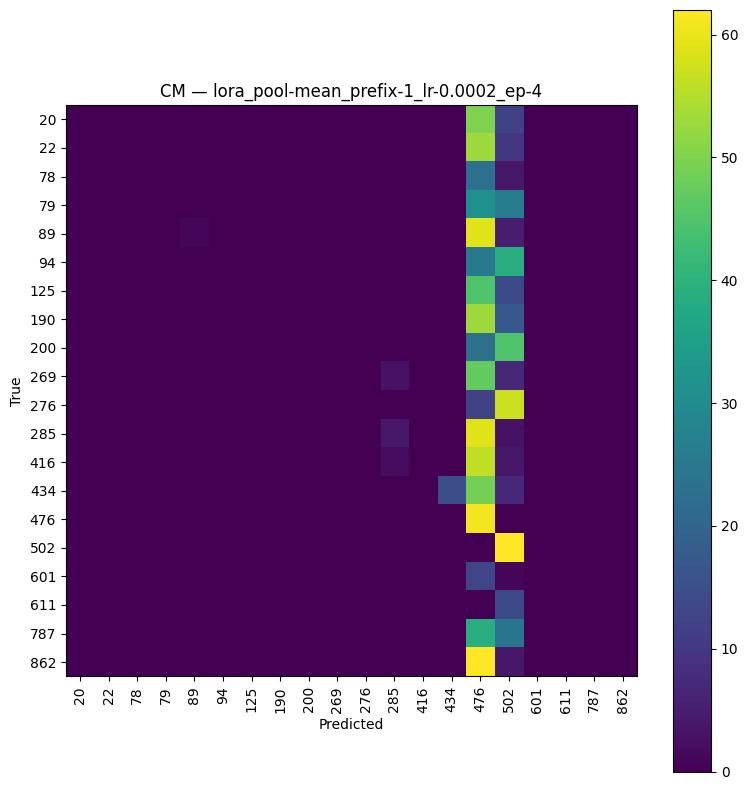

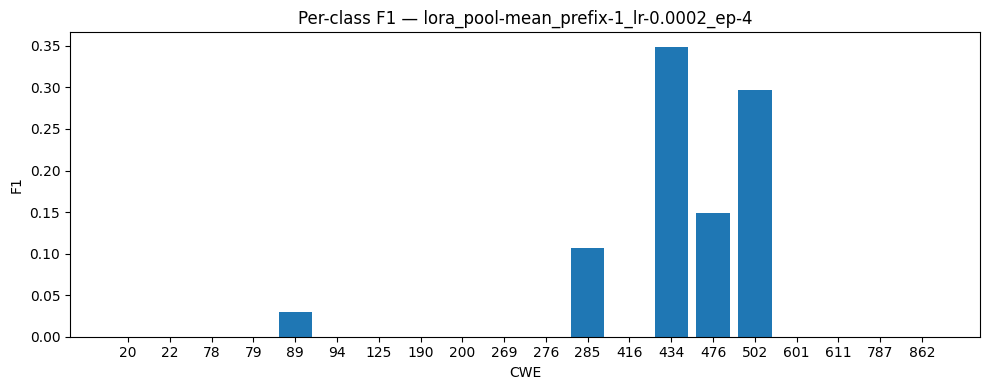

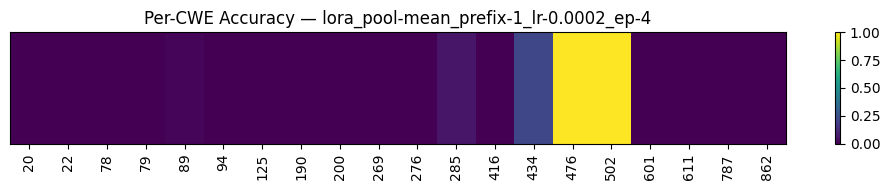

Pred class: 15 | Used prefix: True | Top-6 lines:
   1  score=6.72  [LANG:go][TASK:CWE_CLASSIFICATION]
   3  score=2.46  import ("encoding/xml"; "fmt")
   6  score=1.26   xml.Unmarshal(data, &v) // vulnerable: external entities
   4  score=0.74  func parse(data []byte) {
   2  score=0.50  package main
   5  score=0.43   var v interface{}


In [ ]:

# Example: quick runs you can kick off (comment/uncomment as needed).

# 1) Head-only, mean pooling, prefix on
# run_name, test_results, model = run_experiment(mode="head_only", pooling="mean", use_prefix=True, lr=1e-3, epochs=4)

# 2) Head-only, last-token pooling, prefix on
#run_experiment(mode="head_only", pooling="last", use_prefix=True, lr=1e-3, epochs=4)

# 3) LoRA, mean pooling, prefix on
# run_name, test_results, model = run_experiment(mode="lora", pooling="mean", use_prefix=True, lr=2e-4, epochs=4)

# 4) LoRA, last-token pooling, prefix on
#run_experiment(mode="lora", pooling="last", use_prefix=True, lr=2e-4, epochs=4)

# 5) Prompt prefix ablation (LoRA, mean pooling), prefix off
#run_experiment(mode="lora", pooling="mean", use_prefix=False, lr=2e-4, epochs=4)

agg = explain_example_by_index(
    test_ds, idx=2,
    model=model, tokenizer=tokenizer,
    use_prefix=USE_PREFIX_DEFAULT,
    k=6
)


## 9) Batch grid runner (optional)


=== RUN 1/2 :: {'mode': 'head_only', 'pooling': 'mean', 'use_prefix': True, 'lr': 0.001, 'epochs': 4} ===
[HEAD-ONLY] Trainable params: 30,740 | LR=0.001 | epochs=4
Epoch 1: train_loss=1.0326 | val_f1_macro=0.8508 | val_acc=0.8703
Epoch 2: train_loss=0.4846 | val_f1_macro=0.8821 | val_acc=0.8869
Epoch 3: train_loss=0.4019 | val_f1_macro=0.8810 | val_acc=0.8834
Epoch 4: train_loss=0.3305 | val_f1_macro=0.8807 | val_acc=0.8834
Early stopping.
Saved results to ./owen_experiments/20251013_055919_head_only_pool-mean_prefix-1_lr-0.001_ep-4


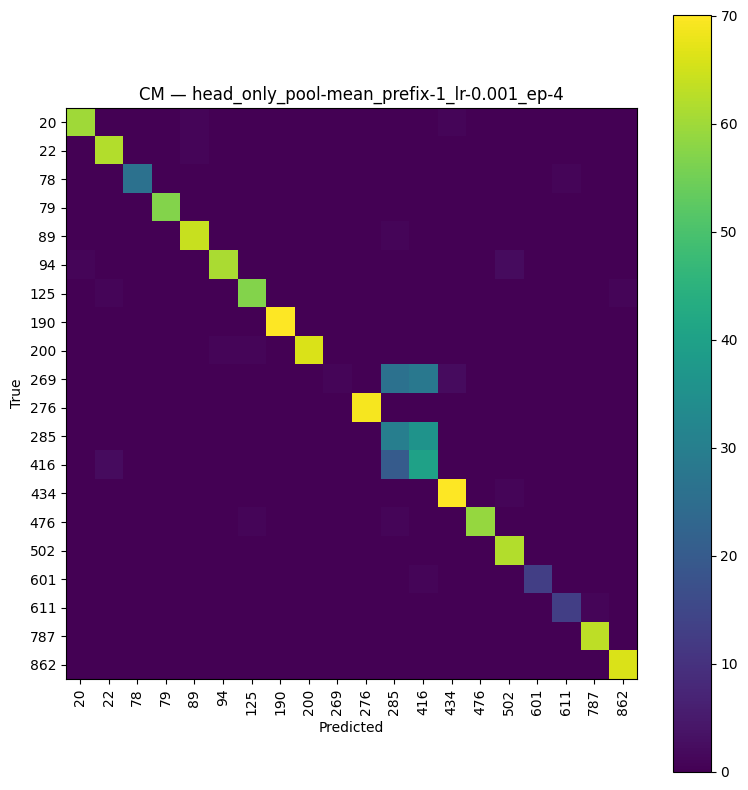

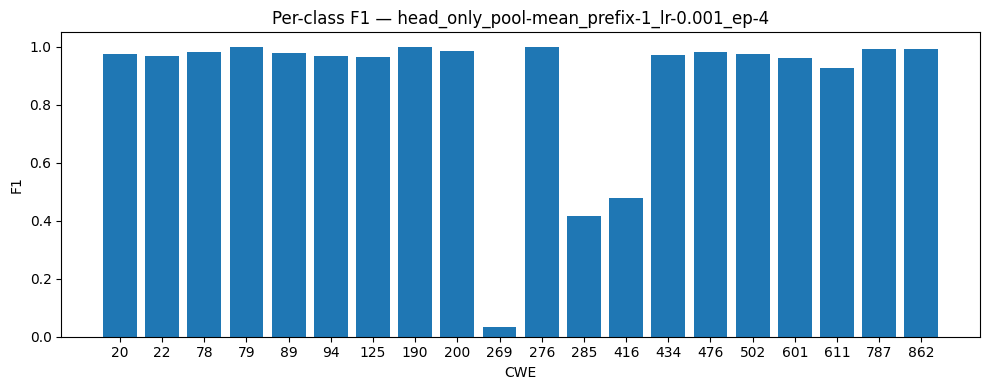

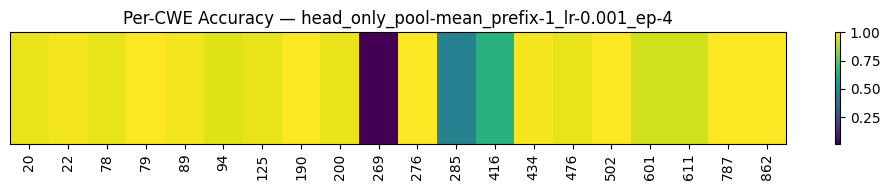

Pred class: 17 | Used prefix: True | Top-6 lines:
   1  score=0.42  [LANG:go][TASK:CWE_CLASSIFICATION]
   3  score=0.22  import ("encoding/xml"; "fmt")
   6  score=0.07   xml.Unmarshal(data, &v) // vulnerable: external entities
   2  score=0.07  package main
   4  score=0.06  func parse(data []byte) {
   5  score=0.04   var v interface{}



=== RUN 2/2 :: {'mode': 'head_only', 'pooling': 'last', 'use_prefix': True, 'lr': 0.001, 'epochs': 4} ===
[HEAD-ONLY] Trainable params: 30,740 | LR=0.001 | epochs=4
Epoch 1: train_loss=1.9953 | val_f1_macro=0.7264 | val_acc=0.7371
Epoch 2: train_loss=0.7840 | val_f1_macro=0.8240 | val_acc=0.8212
Epoch 3: train_loss=0.5572 | val_f1_macro=0.8562 | val_acc=0.8501
Epoch 4: train_loss=0.4178 | val_f1_macro=0.8829 | val_acc=0.8799
Saved results to ./owen_experiments/20251013_060841_head_only_pool-last_prefix-1_lr-0.001_ep-4


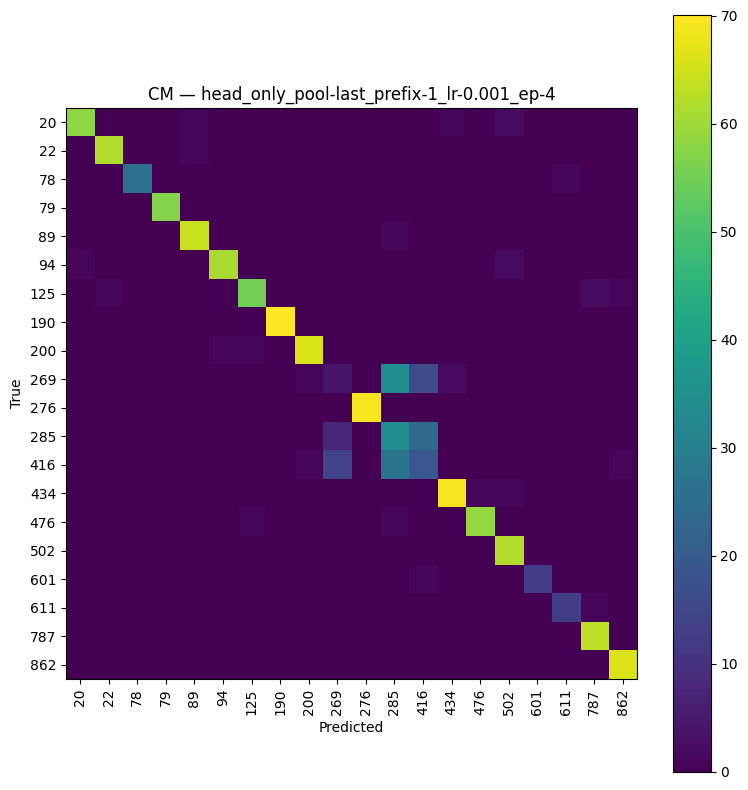

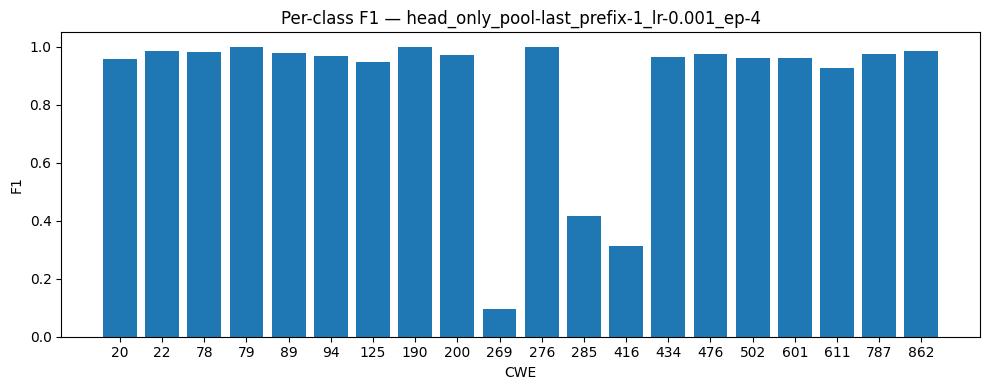

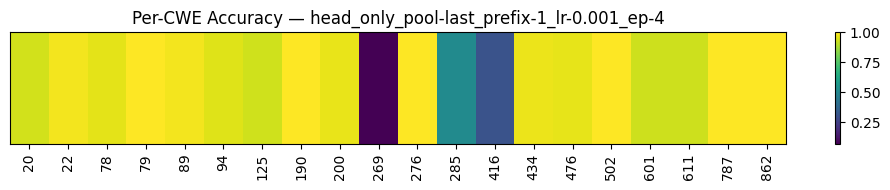

Pred class: 17 | Used prefix: True | Top-6 lines:
   1  score=0.00  [LANG:go][TASK:CWE_CLASSIFICATION]
   2  score=0.00  package main
   3  score=0.00  import ("encoding/xml"; "fmt")
   4  score=0.00  func parse(data []byte) {
   5  score=0.00   var v interface{}
   6  score=0.00   xml.Unmarshal(data, &v) // vulnerable: external entities


                                            run_name       mode pooling  \
0  20251013_055919_head_only_pool-mean_prefix-1_l...  head_only    mean   
1  20251013_060841_head_only_pool-last_prefix-1_l...  head_only    last   

   use_prefix     lr  epochs  accuracy  precision_macro  recall_macro  \
0        True  0.001       4  0.885088         0.921673      0.885839   
1        True  0.001       4  0.868421         0.869901      0.870554   

   f1_macro  inference_time_ms  \
0  0.878014          63.375266   
1  0.868401          61.563554   

                                         top_k_lines  
0  [{'line_idx': 0, 'score': 0.4173126220703125, ...  
1  [{'line_idx': 0, 'score': 0.0, 'text': '[LANG:...  


In [56]:

def run_grid():
    configs = [
        {"mode": "head_only", "pooling": "mean", "use_prefix": True,  "lr": 1e-3,  "epochs": 4},
        {"mode": "head_only", "pooling": "last", "use_prefix": True,  "lr": 1e-3,  "epochs": 4},
        # {"mode": "lora",      "pooling": "mean", "use_prefix": True,  "lr": 2e-4,  "epochs": 4},
        # {"mode": "lora",      "pooling": "last", "use_prefix": True,  "lr": 2e-4,  "epochs": 4},
        # {"mode": "lora",      "pooling": "mean", "use_prefix": False, "lr": 2e-4,  "epochs": 4},
    ]
    summary = []
    for i, cfg in enumerate(configs, 1):
        print(f"\n=== RUN {i}/{len(configs)} :: {cfg} ===")
        run_name, res, model = run_experiment(**cfg)
        agg = explain_example_by_index(
            test_ds, idx=2,
            model=model, tokenizer=tokenizer,
            use_prefix=USE_PREFIX_DEFAULT,
            k=6
        )
        summary.append({
            "run_name": run_name,
            "mode": cfg["mode"],
            "pooling": cfg["pooling"],
            "use_prefix": cfg["use_prefix"],
            "lr": cfg["lr"],
            "epochs": cfg["epochs"],
            "accuracy": res["accuracy"],
            "precision_macro": res["precision_macro"],
            "recall_macro": res["recall_macro"],
            "f1_macro": res["f1_macro"],
            "inference_time_ms": res["inference_time_ms"],
            "top_k_lines": [
                {"line_idx": i, "score": float(sc), "text": ln}
                for (i, sc, ln) in top_k_lines(agg, k=6)
            ]
        })
        
        # free a bit of memory between runs
        torch.cuda.empty_cache()

    df = pd.DataFrame(summary).sort_values("f1_macro", ascending=False)
    df.to_csv(os.path.join(OUTPUT_DIR, "grid_summary.csv"), index=False)
    print(df)
    return df

# To execute the whole grid:
df_summary = run_grid()


## 10) Load & compare saved runs

In [58]:

from glob import glob

def load_saved_results():
    records = []
    for run_dir in sorted(glob(f"{OUTPUT_DIR}/*")):
        jr = os.path.join(run_dir, "eval_results.json")
        if os.path.exists(jr):
            with open(jr, "r", encoding="utf-8") as f:
                res = json.load(f)
            meta = {"run_dir": run_dir}
            # parse suffix if present in folder name for convenience
            records.append({**meta, **res})
    return records

def compare_runs_table(records):
    rows = []
    for r in records:
        # read a config hint from dir name if you used the default suffix
        base = os.path.basename(r["run_dir"])
        rows.append({
            "run_dir": base,
            "accuracy": r["accuracy"],
            "precision_macro": r["precision_macro"],
            "recall_macro": r["recall_macro"],
            "f1_macro": r["f1_macro"],
            "inference_time_ms": r["inference_time_ms"],
        })
    df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
    return df

# Example usage:
recs = load_saved_results()
df = compare_runs_table(recs); df


,run_dir,accuracy,precision_macro,recall_macro,f1_macro,inference_time_ms
1,20251013_040818_head_only_pool-mean_prefix-1_l...,0.878947,0.890104,0.882693,0.883287,63.225012
4,20251013_053421_head_only_pool-mean_prefix-1_l...,0.879825,0.886870,0.881469,0.881938,63.197354
0,20251013_033951_head_only_pool-mean_prefix-1_l...,0.884211,0.904780,0.884810,0.879047,68.975336
2,20251013_042640_head_only_pool-mean_prefix-1_l...,0.877193,0.881000,0.879413,0.878881,63.573167
5,20251013_055919_head_only_pool-mean_prefix-1_l...,0.885088,0.921673,0.885839,0.878014,63.375266
6,20251013_060841_head_only_pool-last_prefix-1_l...,0.868421,0.869901,0.870554,0.868401,61.563554
3,20251013_051511_lora_pool-mean_prefix-1_lr-0.0...,0.125439,0.134968,0.114363,0.046588,85.587590
